## MoCo Demo: CIFAR-10

This is a simple demo for training MoCo on CIFAR-10. It can be run directly in a Colab notebook using a publicly available GPU.

#### Results

These are the ResNet-18 classification accuracy of a **kNN monitor** on the unsupervised pre-training features. 

| config | 200ep | 400ep | 800ep |
| --- | --- | --- | --- |
| Asymmetric | 82.6 | 86.3 | 88.7 |
| Symmetric | 85.3 | 88.5 | 89.7 |

#### Notes

* **Symmetric loss**: the original MoCo paper uses an *asymmetric* loss -- one crop is the query and the other crop is the key, and it backpropagates to one crop (query). Following SimCLR/BYOL, here we provide an option of a *symmetric* loss -- it swaps the two crops and computes an extra loss. The symmetric loss behaves like 2x epochs of the asymmetric counterpart: this may dominate the comparison results when the models are trained with a fixed epoch number.

* **SplitBatchNorm**: the original MoCo was trained in 8 GPUs. To simulate the multi-GPU behavior of BatchNorm in this 1-GPU demo, we provide a SplitBatchNorm layer. We set `--bn-splits 8` by default to simulate 8 GPUs. `--bn-splits 1` is analogous to SyncBatchNorm in the multi-GPU case.

* **kNN monitor**: this demo provides a kNN monitor on the test set. Training a linear classifier on frozen features often achieves higher accuracy. To train a linear classifier (not provided in this demo), we recommend using lr=30, wd=0, epochs=100 with a stepwise or cosine schedule. The ResNet-18 model (kNN 89.7) has 90.7 linear classification accuracy.

#### Disclaimer

This demo aims to provide an interface with a free GPU (thanks to Colab) for understanding how the code runs. We suggest users be careful to draw conclusions from CIFAR, which may not generalize beyond this dataset. We have verified that it is beneficial to have the momentum encoder (disabling it by `--moco-m 0.0` should fail), queue size (saturated at `--moco-k 4096`) and ShuffleBN (without which loses 4% at 800 epochs) on CIFAR, similar to the observations on ImageNet. But new observations made only on CIFAR should be judged with caution.

#### References
This demo is adapted from:
* http://github.com/zhirongw/lemniscate.pytorch
* https://github.com/leftthomas/SimCLR








### Prepare

Check GPU settings. A free GPU in Colab is <= Tesla P100. The log of the demo is based on a Tesla V100 from Google Cloud Platform.


In [1]:
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install transformers
# !pip install Scikit-learn
# !pip uninstall opencv-python
# !pip install opencv-contrib-python

In [2]:
# gpu_info = !nvidia-smi -i 0
# gpu_info = '\n'.join(gpu_info)
# print(gpu_info)

from datetime import datetime
from functools import partial
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.datasets import VisionDataset
from torchvision.models import resnet
from tqdm import tqdm
import argparse
import json
import math
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

/home/yasaisen/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set arguments

In [3]:
# import os
# from google.colab import drive

# drive.mount('/content/drive')
ROOT_PATH = '/home/yasaisen/Desktop/11_research/11_research_main/lab_02/230303'

In [4]:
def checkpath(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
# model

Version = '230301_v0.0.6'

root_folder = os.path.abspath(os.path.join(ROOT_PATH, Version))

# model_DIR = os.path.abspath(os.path.join(root_folder, 'model'))
checkpath(root_folder)

In [6]:
import collections.abc
import math
from dataclasses import dataclass
from typing import Any, Optional, Tuple, Union

import numpy as np
import torch
import torch.utils.checkpoint
from torch import nn

# from ...activations import ACT2FN
from transformers.activations import ACT2FN

# from ...modeling_outputs import BaseModelOutput, BaseModelOutputWithPooling
from transformers.modeling_outputs import BaseModelOutput, BaseModelOutputWithPooling
# from ...modeling_utils import PreTrainedModel
from transformers.modeling_utils import PreTrainedModel
# from ...utils import (
#     ModelOutput,
#     add_start_docstrings,
#     add_start_docstrings_to_model_forward,
#     logging,
#     replace_return_docstrings,
# )
from transformers.utils import (
    ModelOutput,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
# from .configuration_groupvit import GroupViTConfig, GroupViTTextConfig, GroupViTVisionConfig
from transformers.models.groupvit.configuration_groupvit import GroupViTConfig, GroupViTTextConfig, GroupViTVisionConfig



2023-03-06 15:04:49.192469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 15:04:49.294512: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 15:04:49.698469: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-06 15:04:49.698509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [7]:
logger = logging.get_logger(__name__)

_CHECKPOINT_FOR_DOC = "nvidia/groupvit-gcc-yfcc"

GROUPVIT_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "nvidia/groupvit-gcc-yfcc",
    # See all GroupViT models at https://huggingface.co/models?filter=groupvit
]

In [8]:
# Copied from transformers.models.bart.modeling_bart._expand_mask
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)


In [9]:
# contrastive loss function, adapted from
# https://sachinruk.github.io/blog/pytorch/pytorch%20lightning/loss%20function/gpu/2021/03/07/CLIP.html
def contrastive_loss(logits: torch.Tensor) -> torch.Tensor:
    return nn.functional.cross_entropy(logits, torch.arange(len(logits), device=logits.device))

In [10]:
# Copied from transformers.models.clip.modeling_clip.clip_loss with clip->groupvit
def groupvit_loss(similarity: torch.Tensor) -> torch.Tensor:
    caption_loss = contrastive_loss(similarity)
    image_loss = contrastive_loss(similarity.t())
    return (caption_loss + image_loss) / 2.0

In [11]:
def hard_softmax(logits: torch.Tensor, dim: int):
    y_soft = logits.softmax(dim)
    # Straight through.
    index = y_soft.max(dim, keepdim=True)[1]
    y_hard = torch.zeros_like(logits, memory_format=torch.legacy_contiguous_format).scatter_(dim, index, 1.0)
    ret = y_hard - y_soft.detach() + y_soft

    return ret

In [12]:
def gumbel_softmax(logits: torch.Tensor, tau: float = 1, hard: bool = False, dim: int = -1) -> torch.Tensor:
    # more stable https://github.com/pytorch/pytorch/issues/41663
    gumbel_dist = torch.distributions.gumbel.Gumbel(
        torch.tensor(0.0, device=logits.device, dtype=logits.dtype),
        torch.tensor(1.0, device=logits.device, dtype=logits.dtype),
    )
    gumbels = gumbel_dist.sample(logits.shape)

    gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(logits, memory_format=torch.legacy_contiguous_format).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

In [13]:
def resize_attention_map(attentions, height, width, align_corners=False):
    """
    Args:
        attentions (`torch.Tensor`): attention map of shape [batch_size, groups, feat_height*feat_width]
        height (`int`): height of the output attention map
        width (`int`): width of the output attention map
        align_corners (`bool`, *optional*): the `align_corner` argument for `nn.functional.interpolate`.

    Returns:
        `torch.Tensor`: resized attention map of shape [batch_size, groups, height, width]
    """

    scale = (height * width // attentions.shape[2]) ** 0.5
    if height > width:
        feat_width = int(np.round(width / scale))
        feat_height = attentions.shape[2] // feat_width
    else:
        feat_height = int(np.round(height / scale))
        feat_width = attentions.shape[2] // feat_height

    batch_size = attentions.shape[0]
    groups = attentions.shape[1]  # number of group token
    # [batch_size, groups, height*width, groups] -> [batch_size, groups, height, width]
    attentions = attentions.reshape(batch_size, groups, feat_height, feat_width)
    attentions = nn.functional.interpolate(
        attentions, size=(height, width), mode="bilinear", align_corners=align_corners
    )
    return attentions

In [14]:
def get_grouping_from_attentions(attentions, hw_shape):
    """
    Args:
        attentions (`tuple(torch.FloatTensor)`: tuple of attention maps returned by `GroupViTVisionTransformer`
        hw_shape (`tuple(int)`): height and width of the output attention map
    Returns:
        `torch.Tensor`: the attention map of shape [batch_size, groups, height, width]
    """

    attn_maps = []
    with torch.no_grad():
        prev_attn_masks = None
        for attn_masks in attentions:
            # [batch_size, num_groups, height x width] -> [batch_size, height x width, num_groups]
            attn_masks = attn_masks.permute(0, 2, 1).contiguous()
            if prev_attn_masks is None:
                prev_attn_masks = attn_masks
            else:
                prev_attn_masks = prev_attn_masks @ attn_masks
            # [batch_size, heightxwidth, num_groups] -> [batch_size, num_groups, heightxwidth] -> [batch_size, num_groups, height, width]
            cur_attn_map = resize_attention_map(prev_attn_masks.permute(0, 2, 1).contiguous(), *hw_shape)
            attn_maps.append(cur_attn_map)

    # [batch_size, num_groups, height, width]
    final_grouping = attn_maps[-1]

    return final_grouping

In [15]:
class GroupViTCrossAttentionLayer(nn.Module):
    def __init__(self, config: GroupViTVisionConfig):
        super().__init__()
        self.attn = GroupViTAttention(config)
        self.norm2 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.mlp = GroupViTMLP(config)
        self.norm_post = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, query, key):
        x = query
        x = x + self.attn(query, encoder_hidden_states=key)[0]
        x = x + self.mlp(self.norm2(x))
        x = self.norm_post(x)
        return x

In [16]:
class GroupViTAssignAttention(nn.Module):
    def __init__(self, config: GroupViTVisionConfig):
        super().__init__()
        self.scale = config.hidden_size**-0.5

        self.q_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.k_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.v_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.assign_eps = config.assign_eps

    def get_attn(self, attn, gumbel=True, hard=True):
        if gumbel and self.training:
            attn = gumbel_softmax(attn, dim=-2, hard=hard)
        else:
            if hard:
                attn = hard_softmax(attn, dim=-2)
            else:
                attn = nn.functional.softmax(attn, dim=-2)

        return attn

    def forward(self, query, key):
        value = key
        # [batch_size, query_length, channels]
        query = self.q_proj(query)

        # [batch_size, key_length, channels]
        key = self.k_proj(key)

        # [batch_size, key_length, channels]
        value = self.v_proj(value)

        # [batch_size, query_length, key_length]
        raw_attn = (query @ key.transpose(-2, -1)) * self.scale

        attn = self.get_attn(raw_attn)
        soft_attn = self.get_attn(raw_attn, gumbel=False, hard=False)

        attn = attn / (attn.sum(dim=-1, keepdim=True) + self.assign_eps)

        out = attn @ value

        out = self.proj(out)

        return out, soft_attn

In [17]:
class GroupViTTokenAssign(nn.Module):
    def __init__(self, config: GroupViTVisionConfig, num_group_token, num_output_group):
        super().__init__()
        self.num_output_group = num_output_group
        # norm on group_tokens
        self.norm_tokens = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        assign_mlp_ratio = (
            config.assign_mlp_ratio
            if isinstance(config.assign_mlp_ratio, collections.abc.Iterable)
            else (config.assign_mlp_ratio, config.assign_mlp_ratio)
        )
        tokens_dim, channels_dim = [int(x * config.hidden_size) for x in assign_mlp_ratio]
        self.mlp_inter = GroupViTMixerMLP(config, num_group_token, tokens_dim, num_output_group)
        self.norm_post_tokens = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        # norm on x
        self.norm_x = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.pre_assign_attn = GroupViTCrossAttentionLayer(config)

        self.assign = GroupViTAssignAttention(config)
        self.norm_new_x = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.mlp_channels = GroupViTMLP(config, config.hidden_size, channels_dim, config.hidden_size)

    def project_group_token(self, group_tokens):
        """
        Args:
            group_tokens (torch.Tensor): group tokens, [batch_size, num_group_tokens, channels]

        Returns:
            projected_group_tokens (torch.Tensor): [batch_size, num_output_groups, channels]
        """
        # [B, num_output_groups, C] <- [B, num_group_tokens, C]
        projected_group_tokens = self.mlp_inter(group_tokens)
        projected_group_tokens = self.norm_post_tokens(projected_group_tokens)
        return projected_group_tokens

    def forward(self, image_tokens, group_tokens):
        """
        Args:
            image_tokens (`torch.Tensor`): image tokens, of shape [batch_size, input_length, channels]
            group_tokens (`torch.Tensor`): group tokens, [batch_size, num_group_tokens, channels]
        """

        group_tokens = self.norm_tokens(group_tokens)
        image_tokens = self.norm_x(image_tokens)
        # [batch_size, num_output_groups, channels]
        projected_group_tokens = self.project_group_token(group_tokens)
        projected_group_tokens = self.pre_assign_attn(projected_group_tokens, image_tokens)
        new_image_tokens, attention = self.assign(projected_group_tokens, image_tokens)
        new_image_tokens += projected_group_tokens

        new_image_tokens = new_image_tokens + self.mlp_channels(self.norm_new_x(new_image_tokens))

        return new_image_tokens, attention


In [18]:
@dataclass
class GroupViTModelOutput(ModelOutput):
    """
    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `return_loss` is `True`):
            Contrastive loss for image-text similarity.
        logits_per_image (`torch.FloatTensor` of shape `(image_batch_size, text_batch_size)`):
            The scaled dot product scores between `image_embeds` and `text_embeds`. This represents the image-text
            similarity scores.
        logits_per_text (`torch.FloatTensor` of shape `(text_batch_size, image_batch_size)`):
            The scaled dot product scores between `text_embeds` and `image_embeds`. This represents the text-image
            similarity scores.
        segmentation_logits (`torch.FloatTensor` of shape `(batch_size, config.num_labels, logits_height, logits_width)`):
            Classification scores for each pixel.

            <Tip warning={true}>

            The logits returned do not necessarily have the same size as the `pixel_values` passed as inputs. This is
            to avoid doing two interpolations and lose some quality when a user needs to resize the logits to the
            original image size as post-processing. You should always check your logits shape and resize as needed.

            </Tip>

        text_embeds (`torch.FloatTensor` of shape `(batch_size, output_dim`):
            The text embeddings obtained by applying the projection layer to the pooled output of
            [`GroupViTTextModel`].
        image_embeds (`torch.FloatTensor` of shape `(batch_size, output_dim`):
            The image embeddings obtained by applying the projection layer to the pooled output of
            [`GroupViTVisionModel`].
        text_model_output (`BaseModelOutputWithPooling`):
            The output of the [`GroupViTTextModel`].
        vision_model_output (`BaseModelOutputWithPooling`):
            The output of the [`GroupViTVisionModel`].
    """

    loss: Optional[torch.FloatTensor] = None
    logits_per_image: torch.FloatTensor = None
    logits_per_text: torch.FloatTensor = None
    segmentation_logits: torch.FloatTensor = None
    text_embeds: torch.FloatTensor = None
    image_embeds: torch.FloatTensor = None
    text_model_output: BaseModelOutputWithPooling = None
    vision_model_output: BaseModelOutputWithPooling = None

    def to_tuple(self) -> Tuple[Any]:
        return tuple(
            self[k] if k not in ["text_model_output", "vision_model_output"] else getattr(self, k).to_tuple()
            for k in self.keys()
        )

In [19]:
class GroupViTPatchEmbeddings(nn.Module):
    """
    Image to Patch Embedding.
    """

    def __init__(
        self,
        image_size: int = 224,
        patch_size: Union[int, Tuple[int, int]] = 16,
        num_channels: int = 3,
        embed_dim: int = 768,
    ):
        super().__init__()
        image_size = image_size if isinstance(image_size, collections.abc.Iterable) else (image_size, image_size)
        patch_size = patch_size if isinstance(patch_size, collections.abc.Iterable) else (patch_size, patch_size)
        num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.projection = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, pixel_values: torch.Tensor, interpolate_pos_encoding: bool = False) -> torch.Tensor:
        batch_size, num_channels, height, width = pixel_values.shape
        if not interpolate_pos_encoding:
            if height != self.image_size[0] or width != self.image_size[1]:
                raise ValueError(
                    f"Input image size ({height}*{width}) doesn't match model"
                    f" ({self.image_size[0]}*{self.image_size[1]})."
                )
        x = self.projection(pixel_values).flatten(2).transpose(1, 2)
        return x

In [20]:
class GroupViTVisionEmbeddings(nn.Module):
    def __init__(self, config: GroupViTVisionConfig):
        super().__init__()

        self.patch_embeddings = GroupViTPatchEmbeddings(
            image_size=config.image_size,
            patch_size=config.patch_size,
            num_channels=config.num_channels,
            embed_dim=config.hidden_size,
        )
        num_patches = self.patch_embeddings.num_patches
        self.position_embeddings = nn.Parameter(torch.zeros(1, num_patches, config.hidden_size))
        self.dropout = nn.Dropout(config.dropout)
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.config = config

    def interpolate_pos_encoding(self, embeddings: torch.Tensor, height: int, width: int) -> torch.Tensor:
        """
        This method allows to interpolate the pre-trained position encodings, to be able to use the model on higher
        resolution images.

        Source:
        https://github.com/facebookresearch/dino/blob/de9ee3df6cf39fac952ab558447af1fa1365362a/vision_transformer.py#L174
        """

        npatch = embeddings.shape[1]
        if npatch == self.position_embeddings.shape[1] and height == width:
            return self.position_embeddings
        patch_pos_embed = self.position_embeddings
        num_original_pos_embed = patch_pos_embed.shape[1]
        dim = embeddings.shape[-1]
        feat_height = height // self.config.patch_size
        feat_width = width // self.config.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        feat_height, feat_width = feat_height + 0.1, feat_width + 0.1
        original_height = original_width = math.sqrt(num_original_pos_embed)
        reshaped_patch_pos_embed = patch_pos_embed.reshape(1, int(original_height), int(original_width), dim).permute(
            0, 3, 1, 2
        )
        scale_factor = (feat_height / original_height, feat_width / original_width)
        patch_pos_embed = nn.functional.interpolate(
            reshaped_patch_pos_embed,
            scale_factor=scale_factor,
            mode="bicubic",
            align_corners=False,
        )
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return patch_pos_embed

    def forward(self, pixel_values: torch.Tensor, interpolate_pos_encoding: bool = False) -> torch.Tensor:
        batch_size, num_channels, height, width = pixel_values.shape
        embeddings = self.patch_embeddings(pixel_values, interpolate_pos_encoding=interpolate_pos_encoding)

        embeddings = self.layernorm(embeddings)

        batch_size, seq_len, _ = embeddings.size()

        # add positional encoding to each token
        if interpolate_pos_encoding:
            embeddings = embeddings + self.interpolate_pos_encoding(embeddings, height, width)
        else:
            embeddings = embeddings + self.position_embeddings

        embeddings = self.dropout(embeddings)

        return embeddings

In [21]:
# Copied from transformers.models.clip.modeling_clip.CLIPTextEmbeddings with CLIP->GroupViT
class GroupViTTextEmbeddings(nn.Module):
    def __init__(self, config: GroupViTTextConfig):
        super().__init__()
        embed_dim = config.hidden_size

        self.token_embedding = nn.Embedding(config.vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(config.max_position_embeddings, embed_dim)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
    ) -> torch.Tensor:
        seq_length = input_ids.shape[-1] if input_ids is not None else inputs_embeds.shape[-2]

        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length]

        if inputs_embeds is None:
            inputs_embeds = self.token_embedding(input_ids)

        position_embeddings = self.position_embedding(position_ids)
        embeddings = inputs_embeds + position_embeddings

        return embeddings

In [22]:
class GroupViTStage(nn.Module):
    """This corresponds to the `GroupingLayer` class in the GroupViT implementation."""

    def __init__(
        self,
        config: GroupViTVisionConfig,
        depth: int,
        num_prev_group_token: int,
        num_group_token: int,
        num_output_group: int,
    ):
        super().__init__()
        self.depth = depth
        self.num_group_token = num_group_token
        if num_group_token > 0:
            self.group_token = nn.Parameter(torch.zeros(1, num_group_token, config.hidden_size))
        else:
            self.group_token = None
        self.gradient_checkpointing = False
        self.layers = nn.ModuleList([GroupViTEncoderLayer(config) for _ in range(depth)])

        if num_group_token > 0:
            self.downsample = GroupViTTokenAssign(
                config=config,
                num_group_token=num_group_token,
                num_output_group=num_output_group,
            )
        else:
            self.downsample = None

        if num_prev_group_token > 0 and num_group_token > 0:
            self.group_projector = nn.Sequential(
                nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps),
                GroupViTMixerMLP(config, num_prev_group_token, config.hidden_size // 2, num_group_token),
            )
        else:
            self.group_projector = None

    @property
    def with_group_token(self):
        return self.group_token is not None

    def split_x(self, x):
        if self.with_group_token:
            return x[:, : -self.num_group_token], x[:, -self.num_group_token :]
        else:
            return x, None

    def concat_x(self, x: torch.Tensor, group_token: Optional[torch.Tensor] = None) -> torch.Tensor:
        if group_token is None:
            return x
        return torch.cat([x, group_token], dim=1)

    def forward(
        self,
        hidden_states: torch.Tensor,
        prev_group_token: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.FloatTensor]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
                `(config.encoder_attention_heads,)`.
            output_attentions (`bool`, *optional*):
                Whether or not to return the grouping tensors of Grouping block.
        """
        if self.with_group_token:
            group_token = self.group_token.expand(hidden_states.size(0), -1, -1)
            if self.group_projector is not None:
                group_token = group_token + self.group_projector(prev_group_token)
        else:
            group_token = None

        x = hidden_states

        cat_x = self.concat_x(x, group_token)
        for layer in self.layers:
            layer_out = layer(cat_x, attention_mask=None, causal_attention_mask=None)
            cat_x = layer_out[0]

        x, group_token = self.split_x(cat_x)

        attention = None
        if self.downsample is not None:
            x, attention = self.downsample(x, group_token)

        outputs = (x, group_token)
        if output_attentions:
            outputs = outputs + (attention,)

        return outputs

In [23]:
class GroupViTMLP(nn.Module):
    def __init__(
        self,
        config: GroupViTVisionConfig,
        hidden_size: Optional[int] = None,
        intermediate_size: Optional[int] = None,
        output_size: Optional[int] = None,
    ):
        super().__init__()
        self.config = config
        self.activation_fn = ACT2FN[config.hidden_act]
        hidden_size = hidden_size if hidden_size is not None else config.hidden_size
        intermediate_size = intermediate_size if intermediate_size is not None else config.intermediate_size
        output_size = output_size if output_size is not None else hidden_size
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.fc2 = nn.Linear(intermediate_size, output_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        hidden_states = self.activation_fn(hidden_states)
        hidden_states = self.fc2(hidden_states)
        return hidden_states

In [24]:
class GroupViTMixerMLP(GroupViTMLP):
    def forward(self, x):
        x = super().forward(x.transpose(1, 2))
        return x.transpose(1, 2)

In [25]:
class GroupViTAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        if self.head_dim * self.num_heads != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`:"
                f" {self.num_heads})."
            )
        self.scale = self.head_dim**-0.5
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        causal_attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        bsz, tgt_len, embed_dim = hidden_states.size()
        is_cross_attention = encoder_hidden_states is not None

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scale
        if is_cross_attention:
            key_states = self._shape(self.k_proj(encoder_hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(encoder_hidden_states), -1, bsz)
        else:
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.view(*proj_shape)
        value_states = value_states.view(*proj_shape)

        src_len = key_states.size(1)
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        # apply the causal_attention_mask first
        if causal_attention_mask is not None:
            if causal_attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is"
                    f" {causal_attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + causal_attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if output_attentions:
            # this operation is a bit akward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)
        attn_output = attn_output.reshape(bsz, tgt_len, embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped


In [26]:
# Copied from transformers.models.clip.modeling_clip.CLIPEncoderLayer with CLIP->GroupViT
class GroupViTEncoderLayer(nn.Module):
    def __init__(self, config: GroupViTConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = GroupViTAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = GroupViTMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: torch.Tensor,
        causal_attention_mask: torch.Tensor,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.FloatTensor]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
                `(config.encoder_attention_heads,)`.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states

        hidden_states = self.layer_norm1(hidden_states)
        hidden_states, attn_weights = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
        )
        hidden_states = residual + hidden_states

        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (attn_weights,)

        return outputs

In [27]:
class GroupViTPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """

    config_class = GroupViTConfig
    base_model_prefix = "groupvit"
    supports_gradient_checkpointing = True
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def _init_weights(self, module):
        """Initialize the weights"""

        init_range = self.config.initializer_range
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=init_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

        factor = self.config.initializer_factor
        if isinstance(module, GroupViTTextEmbeddings):
            module.token_embedding.weight.data.normal_(mean=0.0, std=factor * 0.02)
            module.position_embedding.weight.data.normal_(mean=0.0, std=factor * 0.02)
        elif isinstance(module, GroupViTAttention):
            factor = self.config.initializer_factor
            in_proj_std = (module.embed_dim**-0.5) * ((2 * module.config.num_hidden_layers) ** -0.5) * factor
            out_proj_std = (module.embed_dim**-0.5) * factor
            nn.init.normal_(module.q_proj.weight, std=in_proj_std)
            nn.init.normal_(module.k_proj.weight, std=in_proj_std)
            nn.init.normal_(module.v_proj.weight, std=in_proj_std)
            nn.init.normal_(module.out_proj.weight, std=out_proj_std)
        elif isinstance(module, GroupViTMLP):
            factor = self.config.initializer_factor
            in_proj_std = (
                (module.config.hidden_size**-0.5) * ((2 * module.config.num_hidden_layers) ** -0.5) * factor
            )
            fc_std = (2 * module.config.hidden_size) ** -0.5 * factor
            nn.init.normal_(module.fc1.weight, std=fc_std)
            nn.init.normal_(module.fc2.weight, std=in_proj_std)

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, (GroupViTTextEncoder, GroupViTVisionEncoder)):
            module.gradient_checkpointing = value

In [28]:
GROUPVIT_START_DOCSTRING = r"""
    This model is a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass. Use it
    as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage and
    behavior.

    Parameters:
        config ([`GroupViTConfig`]): Model configuration class with all the parameters of the model.
            Initializing with a config file does not load the weights associated with the model, only the
            configuration. Check out the [`~PreTrainedModel.from_pretrained`] method to load the model weights.
"""

GROUPVIT_TEXT_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you provide
            it.

            Indices can be obtained using [`CLIPTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)
        position_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
            config.max_position_embeddings - 1]`.

            [What are position IDs?](../glossary#position-ids)
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

GROUPVIT_VISION_INPUTS_DOCSTRING = r"""
    Args:
        pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
            Pixel values. Padding will be ignored by default should you provide it. Pixel values can be obtained using
            [`AutoImageProcessor`]. See [`CLIPImageProcessor.__call__`] for details.
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

GROUPVIT_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you provide
            it.

            Indices can be obtained using [`CLIPTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)
        position_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
            config.max_position_embeddings - 1]`.

            [What are position IDs?](../glossary#position-ids)
        pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
            Pixel values. Pixel values can be obtained using [`AutoImageProcessor`]. See
            [`CLIPImageProcessor.__call__`] for details.
        return_loss (`bool`, *optional*):
            Whether or not to return the contrastive loss.
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

In [29]:
class GroupViTVisionEncoder(nn.Module):
    def __init__(self, config: GroupViTVisionConfig) -> None:
        super().__init__()
        self.config = config
        self.stages = nn.ModuleList(
            [
                GroupViTStage(
                    config=config,
                    depth=config.depths[i],
                    num_group_token=config.num_group_tokens[i],
                    num_output_group=config.num_output_groups[i],
                    num_prev_group_token=config.num_output_groups[i - 1] if i > 0 else 0,
                )
                for i in range(len(config.depths))
            ]
        )
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        output_hidden_states: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple, BaseModelOutput]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        all_hidden_states = () if output_hidden_states else None
        all_groupings = () if output_attentions else None

        group_tokens = None

        for i, stage in enumerate(self.stages):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = stage(hidden_states, group_tokens, output_attentions)

            hidden_states = layer_outputs[0]
            group_tokens = layer_outputs[1]

            if output_attentions and layer_outputs[2] is not None:
                all_groupings = all_groupings + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_groupings] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=all_hidden_states, attentions=all_groupings
        )

In [30]:
class GroupViTTextEncoder(nn.Module):
    """
    Transformer encoder consisting of `config.num_hidden_layers` self-attention layers. Each layer is a
    [`GroupViTEncoderLayer`].

    Args:
        config: GroupViTTextConfig
    """

    def __init__(self, config: GroupViTTextConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList([GroupViTEncoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
        self,
        inputs_embeds,
        attention_mask: Optional[torch.Tensor] = None,
        causal_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutput]:
        r"""
        Args:
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation.
                This is useful if you want more control over how to convert `input_ids` indices into associated vectors
                than the model's internal embedding lookup matrix.
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            causal_attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Causal mask for the text model. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None

        hidden_states = inputs_embeds
        for idx, encoder_layer in enumerate(self.layers):
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(encoder_layer),
                    hidden_states,
                    attention_mask,
                    causal_attention_mask,
                )
            else:
                layer_outputs = encoder_layer(
                    hidden_states,
                    attention_mask,
                    causal_attention_mask,
                    output_attentions=output_attentions,
                )

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=encoder_states, attentions=all_attentions
        )

In [31]:
# Copied from transformers.models.clip.modeling_clip.CLIPTextTransformer with CLIPText->GroupViTText, CLIPEncoder->GroupViTTextEncoder, CLIP_TEXT->GROUPVIT_TEXT
class GroupViTTextTransformer(nn.Module):
    def __init__(self, config: GroupViTTextConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = GroupViTTextEmbeddings(config)
        self.encoder = GroupViTTextEncoder(config)
        self.final_layer_norm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    @add_start_docstrings_to_model_forward(GROUPVIT_TEXT_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=GroupViTTextConfig)
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if input_ids is None:
            raise ValueError("You have to specify input_ids")

        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_shape[-1])

        hidden_states = self.embeddings(input_ids=input_ids, position_ids=position_ids)

        bsz, seq_len = input_shape
        # CLIP's text model uses causal mask, prepare it here.
        # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324
        causal_attention_mask = self._build_causal_attention_mask(bsz, seq_len, hidden_states.dtype).to(
            hidden_states.device
        )
        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, hidden_states.dtype)

        encoder_outputs = self.encoder(
            inputs_embeds=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        last_hidden_state = encoder_outputs[0]
        last_hidden_state = self.final_layer_norm(last_hidden_state)

        # text_embeds.shape = [batch_size, sequence_length, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        # casting to torch.int for onnx compatibility: argmax doesn't support int64 inputs with opset 14
        pooled_output = last_hidden_state[
            torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
            input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
        ]

        if not return_dict:
            return (last_hidden_state, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

    def _build_causal_attention_mask(self, bsz, seq_len, dtype):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(bsz, seq_len, seq_len, dtype=dtype)
        mask.fill_(torch.tensor(torch.finfo(dtype).min))
        mask.triu_(1)  # zero out the lower diagonal
        mask = mask.unsqueeze(1)  # expand mask
        return mask

In [32]:
class GroupViTTextModel(GroupViTPreTrainedModel):
    config_class = GroupViTTextConfig

    def __init__(self, config: GroupViTTextConfig):
        super().__init__(config)
        self.text_model = GroupViTTextTransformer(config)
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self) -> nn.Module:
        return self.text_model.embeddings.token_embedding

    def set_input_embeddings(self, value):
        self.text_model.embeddings.token_embedding = value

    @add_start_docstrings_to_model_forward(GROUPVIT_TEXT_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=GroupViTTextConfig)
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from transformers import CLIPTokenizer, GroupViTTextModel

        >>> tokenizer = CLIPTokenizer.from_pretrained("nvidia/groupvit-gcc-yfcc")
        >>> model = GroupViTTextModel.from_pretrained("nvidia/groupvit-gcc-yfcc")

        >>> inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")

        >>> outputs = model(**inputs)
        >>> last_hidden_state = outputs.last_hidden_state
        >>> pooled_output = outputs.pooler_output  # pooled (EOS token) states
        ```"""
        return self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

In [33]:
class GroupViTVisionTransformer(nn.Module):########################
    def __init__(self, config: GroupViTVisionConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size

        self.embeddings = GroupViTVisionEmbeddings(config)
        self.encoder = GroupViTVisionEncoder(config)
        self.layernorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    @add_start_docstrings_to_model_forward(GROUPVIT_VISION_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=GroupViTVisionConfig)
    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        output_hidden_states: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        hidden_states = self.embeddings(pixel_values)

        encoder_outputs = self.encoder(
            hidden_states=hidden_states,
            output_hidden_states=output_hidden_states,
            output_attentions=output_attentions,
            return_dict=return_dict,
        )

        last_hidden_state = encoder_outputs[0]

        # normalize the last hidden state
        last_hidden_state = self.layernorm(last_hidden_state)
        pooled_output = last_hidden_state.mean(dim=1)

        if not return_dict:
            return (last_hidden_state, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

In [34]:
class GroupViTVisionModel(GroupViTPreTrainedModel):
    config_class = GroupViTVisionConfig
    main_input_name = "pixel_values"

    def __init__(self, config: GroupViTVisionConfig):
        super().__init__(config)
        self.vision_model = GroupViTVisionTransformer(config)

        self.projection_dim = 128
        self.projection_intermediate_dim = 4096
        self.vision_embed_dim = config.hidden_size

        self.visual_projection = nn.Sequential(
            nn.Linear(self.vision_embed_dim, self.projection_intermediate_dim, bias=True),
            nn.BatchNorm1d(self.projection_intermediate_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_intermediate_dim, self.projection_dim, bias=True),
        )

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self) -> GroupViTPatchEmbeddings:
        return self.vision_model.embeddings.patch_embeddings

    @add_start_docstrings_to_model_forward(GROUPVIT_VISION_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=GroupViTVisionConfig)
    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, GroupViTVisionModel

        >>> processor = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-yfcc")
        >>> model = GroupViTVisionModel.from_pretrained("nvidia/groupvit-gcc-yfcc")

        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)

        >>> inputs = processor(images=image, return_tensors="pt")

        >>> outputs = model(**inputs)
        >>> last_hidden_state = outputs.last_hidden_state
        >>> pooled_output = outputs.pooler_output  # pooled CLS states
        ```"""

        # print(type(pixel_values), type(output_attentions), type(output_hidden_states), type(return_dict))
        # print(pixel_values.shape, output_attentions, output_hidden_states, return_dict)
        # print('pixel_values=', pixel_values.shape)
        output_attentions = True
        output_hidden_states = False
        return_dict = True
        # print(pixel_values.shape, output_attentions, output_hidden_states, return_dict)
        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        # print(vision_outputs)

        attentions = vision_outputs[2]
            
        # [batch_size_image, num_group, height, width]
        grouping = get_grouping_from_attentions(attentions, pixel_values.shape[2:])
        seg_logits = grouping

        pooled_output = vision_outputs[1]  # pooled_output
        image_features = self.visual_projection(pooled_output)

        # print(image_features.shape)
        return vision_outputs, seg_logits, image_features

In [35]:
@add_start_docstrings(GROUPVIT_START_DOCSTRING)
class GroupViTModel(GroupViTPreTrainedModel):
    config_class = GroupViTConfig

    def __init__(self, config: GroupViTConfig):
        super().__init__(config)

        # if not isinstance(config.text_config, GroupViTTextConfig):
        #     raise ValueError(
        #         "config.text_config is expected to be of type GroupViTTextConfig but is of type"
        #         f" {type(config.text_config)}."
        #     )

        if not isinstance(config.vision_config, GroupViTVisionConfig):
            raise ValueError(
                "config.vision_config is expected to be of type GroupViTVisionConfig but is of type"
                f" {type(config.vision_config)}."
            )

        # text_config = config.text_config
        vision_config = config.vision_config

        self.projection_dim = config.projection_dim
        self.projection_intermediate_dim = config.projection_intermediate_dim
        # self.text_embed_dim = text_config.hidden_size
        self.vision_embed_dim = vision_config.hidden_size
        print('hidden_size', vision_config.hidden_size)

        # self.text_model = GroupViTTextTransformer(text_config)
        self.vision_model = GroupViTVisionTransformer(vision_config)

        self.visual_projection = nn.Sequential(
            nn.Linear(self.vision_embed_dim, self.projection_intermediate_dim, bias=True),
            nn.BatchNorm1d(self.projection_intermediate_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_intermediate_dim, self.projection_dim, bias=True),
        )
        # self.text_projection = nn.Sequential(
        #     nn.Linear(self.text_embed_dim, self.projection_intermediate_dim, bias=True),
        #     nn.BatchNorm1d(self.projection_intermediate_dim),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(self.projection_intermediate_dim, self.projection_dim, bias=True),
        # )
        self.logit_scale = nn.Parameter(torch.ones([]) * self.config.logit_scale_init_value)

        # Initialize weights and apply final processing
        self.post_init()

    # @add_start_docstrings_to_model_forward(GROUPVIT_TEXT_INPUTS_DOCSTRING)
    # def get_text_features(
    #     self,
    #     input_ids: Optional[torch.Tensor] = None,
    #     attention_mask: Optional[torch.Tensor] = None,
    #     position_ids: Optional[torch.Tensor] = None,
    #     output_attentions: Optional[bool] = None,
    #     output_hidden_states: Optional[bool] = None,
    #     return_dict: Optional[bool] = None,
    # ) -> torch.FloatTensor:
    #     r"""
    #     Returns:
    #         text_features (`torch.FloatTensor` of shape `(batch_size, output_dim`): The text embeddings obtained by
    #         applying the projection layer to the pooled output of [`GroupViTTextModel`].

    #     Examples:

    #     ```python
    #     >>> from transformers import CLIPTokenizer, GroupViTModel

    #     >>> model = GroupViTModel.from_pretrained("nvidia/groupvit-gcc-yfcc")
    #     >>> tokenizer = CLIPTokenizer.from_pretrained("nvidia/groupvit-gcc-yfcc")

    #     >>> inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")
    #     >>> text_features = model.get_text_features(**inputs)
    #     ```"""
    #     # Use GROUPVIT model's config for some fields (if specified) instead of those of vision & text components.
    #     output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    #     output_hidden_states = (
    #         output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    #     )
    #     return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    #     text_outputs = self.text_model(
    #         input_ids=input_ids,
    #         attention_mask=attention_mask,
    #         position_ids=position_ids,
    #         output_attentions=output_attentions,
    #         output_hidden_states=output_hidden_states,
    #         return_dict=return_dict,
    #     )

    #     pooled_output = text_outputs[1]
    #     text_features = self.text_projection(pooled_output)

    #     return text_features

    @add_start_docstrings_to_model_forward(GROUPVIT_VISION_INPUTS_DOCSTRING)
    def get_image_features(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> torch.FloatTensor:
        r"""
        Returns:
            image_features (`torch.FloatTensor` of shape `(batch_size, output_dim`): The image embeddings obtained by
            applying the projection layer to the pooled output of [`GroupViTVisionModel`].

        Examples:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, GroupViTModel

        >>> model = GroupViTModel.from_pretrained("nvidia/groupvit-gcc-yfcc")
        >>> processor = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-yfcc")

        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)

        >>> inputs = processor(images=image, return_tensors="pt")

        >>> image_features = model.get_image_features(**inputs)
        ```"""
        # Use GROUPVIT model's config for some fields (if specified) instead of those of vision & text components.
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        print(pixel_values.shape, output_attentions, output_hidden_states, return_dict)

        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = vision_outputs[1]  # pooled_output
        print('01 ', pooled_output.shape)

        image_features = self.visual_projection(pooled_output)
        print('02 ', image_features.shape)

        return image_features

    @add_start_docstrings_to_model_forward(GROUPVIT_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=GroupViTModelOutput, config_class=GroupViTConfig)
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        pixel_values: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        return_loss: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_segmentation: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, GroupViTModelOutput]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, GroupViTModel

        >>> model = GroupViTModel.from_pretrained("nvidia/groupvit-gcc-yfcc")
        >>> processor = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-yfcc")

        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)

        >>> inputs = processor(
        ...     text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True
        ... )

        >>> outputs = model(**inputs)
        >>> logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        >>> probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
        ```"""
        # Use GROUPVIT model's config for some fields (if specified) instead of those of vision & text components.
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_segmentation = (
            output_segmentation if output_segmentation is not None else self.config.output_segmentation
        )
        if output_segmentation:
            output_attentions = True
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # print(type(pixel_values), type(output_attentions), type(output_hidden_states), type(return_dict))
        print(pixel_values.shape, output_attentions, output_hidden_states, return_dict)

        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        # print(vision_outputs)

        # text_outputs = self.text_model(
        #     input_ids=input_ids,
        #     attention_mask=attention_mask,
        #     position_ids=position_ids,
        #     output_attentions=output_attentions,
        #     output_hidden_states=output_hidden_states,
        #     return_dict=return_dict,
        # )

        image_embeds = vision_outputs[1]
        image_embeds = self.visual_projection(image_embeds)

        # text_embeds = text_outputs[1]
        # text_embeds = self.text_projection(text_embeds)

        # normalized features
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        # text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        # logit_scale = self.logit_scale.exp()
        # logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale
        # logits_per_image = logits_per_text.t()

        seg_logits = None
        if output_segmentation:
            # grouped features
            # [batch_size_image, num_group, hidden_size]
            image_group_embeds = vision_outputs[0]
            print('image_group_embeds_01', image_group_embeds.shape, type(image_group_embeds)) # torch.Size([1, 8, 384]) <class 'torch.Tensor'>

            # [batch_size_image*num_group, hidden_size]
            image_group_embeds = self.visual_projection(image_group_embeds.reshape(-1, image_group_embeds.shape[-1]))
            print('image_group_embeds_02', image_group_embeds.shape, type(image_group_embeds)) # torch.Size([8, 256]) <class 'torch.Tensor'>

            if output_hidden_states:
                attentions = vision_outputs[3]
                print('attentions_01', attentions.shape, type(attentions)) # *

            else:
                attentions = vision_outputs[2]
                print('attentions_02', attentions[0].shape, type(attentions[0]), attentions[1].shape, type(attentions[1])) # torch.Size([1, 64, 196]) torch.Size([1, 8, 64]) <class 'torch.Tensor'>
                
            # [batch_size_image, num_group, height, width]
            grouping = get_grouping_from_attentions(attentions, pixel_values.shape[2:])
            print(pixel_values.shape)
            print(pixel_values.shape[2:])
            print('grouping_01', grouping.shape, type(grouping)) # torch.Size([1, 8, 224, 224]) <class 'torch.Tensor'>
            seg_logits = grouping

            # # normalized features
            # image_group_embeds = image_group_embeds / image_group_embeds.norm(dim=-1, keepdim=True)
            # print('image_group_embeds_03', image_group_embeds.shape, type(image_group_embeds)) # torch.Size([8, 256]) <class 'torch.Tensor'>

            # # [batch_size_image x num_group, batch_size_text]
            # logits_per_image_group = torch.matmul(image_group_embeds, text_embeds.t()) * logit_scale
            # print('logits_per_image_group_01', logits_per_image_group.shape, type(logits_per_image_group)) # torch.Size([8, 3]) <class 'torch.Tensor'>

            # # [batch_size_image, batch_size_text, num_group]
            # logits_per_image_group = logits_per_image_group.reshape(
            #     image_embeds.shape[0], -1, text_embeds.shape[0]
            # ).permute(0, 2, 1)
            # print('logits_per_image_group_02', logits_per_image_group.shape, type(logits_per_image_group)) # torch.Size([1, 3, 8]) <class 'torch.Tensor'>


            # # [batch_size_image, batch_size_text, height x width]
            # flatten_grouping = grouping.reshape(grouping.shape[0], grouping.shape[1], -1)
            # print('flatten_grouping_01', flatten_grouping.shape, type(flatten_grouping)) # torch.Size([1, 8, 50176]) <class 'torch.Tensor'>


            # # [batch_size_image, batch_size_text, height, width]
            # seg_logits = torch.matmul(logits_per_image_group, flatten_grouping) * logit_scale
            # print('seg_logits_01', seg_logits.shape, type(seg_logits)) # torch.Size([1, 3, 50176]) <class 'torch.Tensor'>

            # seg_logits = seg_logits.reshape(
            #     seg_logits.shape[0], seg_logits.shape[1], grouping.shape[2], grouping.shape[3]
            # )
            # print('seg_logits_02', seg_logits.shape, type(seg_logits)) # torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>

        loss = None
        if return_loss:
            loss = groupvit_loss(logits_per_text)

        if not return_dict:
            if seg_logits is not None:
                output = (
                    logits_per_image,
                    logits_per_text,
                    seg_logits,
                    text_embeds,
                    image_embeds,
                    text_outputs,
                    vision_outputs,
                )
            else:
                output = (logits_per_image, logits_per_text, text_embeds, image_embeds, text_outputs, vision_outputs)
            return ((loss,) + output) if loss is not None else output

        return GroupViTModelOutput(
            loss=loss,
            # logits_per_image=logits_per_image,
            # logits_per_text=logits_per_text,
            segmentation_logits=seg_logits,
            # text_embeds=text_embeds,
            image_embeds=image_embeds,
            # text_model_output=text_outputs,
            vision_model_output=vision_outputs,
        )

model import end

In [36]:
parser = argparse.ArgumentParser(description='Train MoCo on CIFAR-10')

parser.add_argument('-a', '--arch', default='resnet18')

# lr: 0.06 for batch 512 (or 0.03 for batch 256)
parser.add_argument('--lr', '--learning-rate', default=0.007, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int, help='learning rate schedule (when to drop lr by 10x); does not take effect if --cos is on')
parser.add_argument('--cos', action='store_true', help='use cosine lr schedule')

parser.add_argument('--batch-size', default=8, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--wd', default=5e-4, type=float, metavar='W', help='weight decay')

# moco specific configs:
parser.add_argument('--moco-dim', default=128, type=int, help='feature dimension')
parser.add_argument('--moco-k', default=4096, type=int, help='queue size; number of negative keys')
parser.add_argument('--moco-m', default=0.99, type=float, help='moco momentum of updating key encoder')
parser.add_argument('--moco-t', default=0.1, type=float, help='softmax temperature')

parser.add_argument('--bn-splits', default=8, type=int, help='simulate multi-gpu behavior of BatchNorm in one gpu; 1 is SyncBatchNorm in multi-gpu')

parser.add_argument('--symmetric', action='store_true', help='use a symmetric loss function that backprops to both crops')

# knn monitor
parser.add_argument('--knn-k', default=200, type=int, help='k in kNN monitor')
parser.add_argument('--knn-t', default=0.1, type=float, help='softmax temperature in kNN monitor; could be different with moco-t')

# utils
parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--results-dir', default='', type=str, metavar='PATH', help='path to cache (default: none)')

'''
args = parser.parse_args()  # running in command line
'''
args = parser.parse_args('')  # running in ipynb

# set command line arguments here when running in ipynb
args.epochs = 200
args.cos = True
args.schedule = []  # cos in use
args.symmetric = False
if args.results_dir == '':
    args.results_dir = root_folder + datetime.now().strftime("%Y-%m-%d-%H-%M-%S-moco")

print(args)

Namespace(arch='resnet18', batch_size=8, bn_splits=8, cos=True, epochs=200, knn_k=200, knn_t=0.1, lr=0.007, moco_dim=128, moco_k=4096, moco_m=0.99, moco_t=0.1, results_dir='/home/yasaisen/Desktop/11_research/11_research_main/lab_02/230303/230301_v0.0.62023-03-06-15-04-51-moco', resume='', schedule=[], symmetric=False, wd=0.0005)


### Define data loaders

In [37]:
# import torchvision.transforms as T
# from transformers import AutoProcessor

In [38]:
# def processor(tensor):
#     processor = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-yfcc")
#     transform = T.ToPILImage()

#     img = transform(tensor)
#     inputs = processor(images=img, return_tensors="pt")
#     pixel_values = np.array(inputs["pixel_values"])
#     pixel_values = pixel_values.squeeze()
#     pixel_values = torch.tensor(pixel_values)

#     return pixel_values

In [39]:
import os
root_dir = ROOT_PATH

In [40]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F

import random
import os, shutil
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# import segmentation_models_pytorch as smp

%matplotlib inline

In [41]:
class Config:
    
    data_dir = os.path.join(root_dir, "kaggle_3m/")
    
    validation_fraction = 0.15
    test_fraction = 0.10
    train_batch = 16
    valid_batch = 32
    test_batch = 32
    
    input_dim = 256
    input_ch = 3
    output_dim = 256
    output_ch = 1
    
    seed = 1
    learning_rate = 0.01
    epochs = 30
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [42]:
def plot_example(idx):
    base_path = Config.data_dir+ test_df['directory'].iloc[idx]
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")
    plt.show()

In [43]:
dirs, images, masks = [], [], []

i =0

for root, folders, files in  os.walk(Config.data_dir):
    for file in files:
        if 'mask' in file:
            dirs.append(root.replace(Config.data_dir, ''))
            masks.append(file)
            images.append(file.replace("_mask", ""))

PathDF = pd.DataFrame({'directory': dirs,
                      'images': images,
                      'masks': masks})
PathDF.head()

,directory,images,masks
0,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_16.tif,TCGA_HT_7690_19960312_16_mask.tif
1,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_10.tif,TCGA_HT_7690_19960312_10_mask.tif
2,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_18.tif,TCGA_HT_7690_19960312_18_mask.tif
3,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_17.tif,TCGA_HT_7690_19960312_17_mask.tif
4,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_9.tif,TCGA_HT_7690_19960312_9_mask.tif


In [44]:
for i in PathDF.index:
    PathDF.loc[i, "diagnosis"] = 1 if np.max(cv2.imread(os.path.join(Config.data_dir, PathDF.loc[i, 'directory'], PathDF.loc[i,"masks"]))) > 0 else 0

In [45]:
PathDF.head()

,directory,images,masks,diagnosis
0,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_16.tif,TCGA_HT_7690_19960312_16_mask.tif,1.0
1,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_10.tif,TCGA_HT_7690_19960312_10_mask.tif,0.0
2,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_18.tif,TCGA_HT_7690_19960312_18_mask.tif,1.0
3,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_17.tif,TCGA_HT_7690_19960312_17_mask.tif,1.0
4,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_9.tif,TCGA_HT_7690_19960312_9_mask.tif,0.0


In [46]:
PathDF['diagnosis'].value_counts()

0.0    2556
1.0    1373
Name: diagnosis, dtype: int64

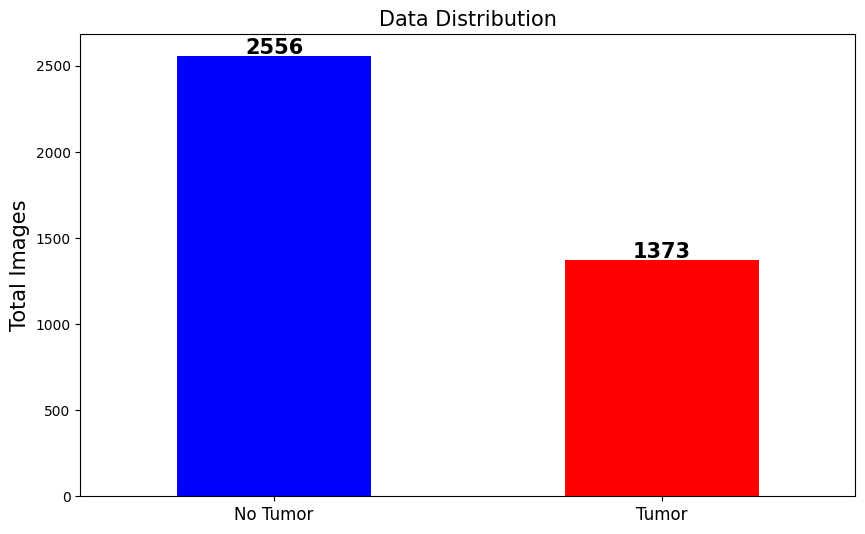

In [47]:
ax = PathDF['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(PathDF['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

Train: 2946
Valid: 590
Test: 393


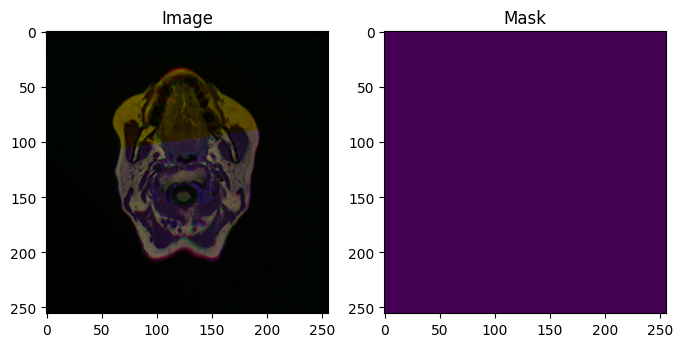

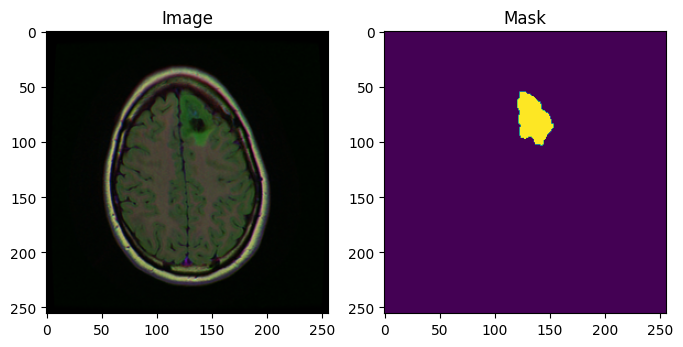

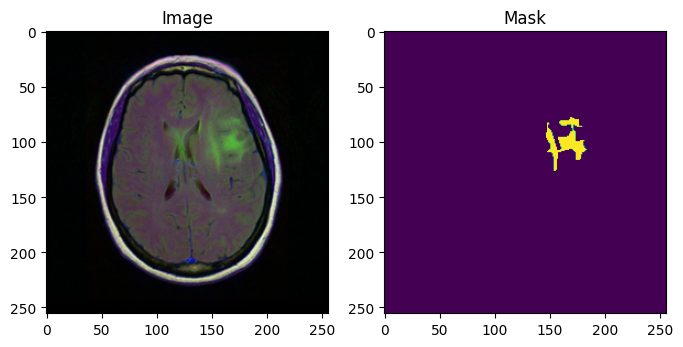

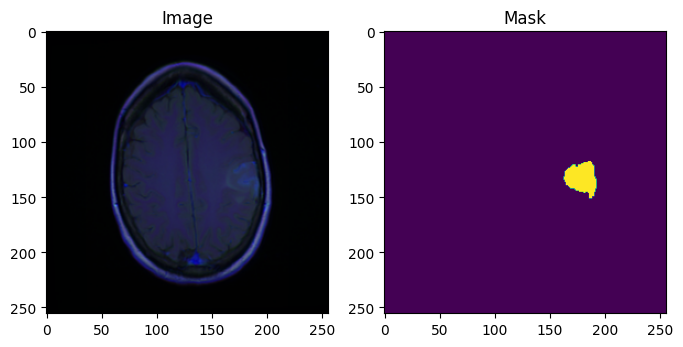

In [48]:
train2rest = Config.validation_fraction + Config.test_fraction
test2valid = Config.validation_fraction / train2rest

train_df, rest = train_test_split(PathDF, random_state=Config.seed,
                                 test_size = train2rest)

test_df, valid_df = train_test_split(rest, random_state=Config.seed,
                                    test_size = test2valid)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])
print('Test:', test_df.shape[0])
plot_example(0)
plot_example(5)
plot_example(10)
plot_example(20)

In [49]:
class MRI_Dataset(Dataset):
    def __init__(self, path_df, transform=None):

        self.path_df = path_df
        self.transform = transform
        self.classes = ['No Tumor', 'Tumor']
        self.img = []
        self.targets = []

        for idx in range(self.path_df.shape[0]):
            base_path = os.path.join(Config.data_dir, self.path_df.iloc[idx]['directory'])
        
            self.img += [os.path.join(base_path, self.path_df.iloc[idx]['images'])]
            self.targets += [int(self.path_df.iloc[idx]['diagnosis'])+1]

    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):

        if self.transform is not None:
            _img = self.transform(Image.open(self.img[idx]))
            
        return _img, self.targets[idx]

In [50]:
class MRI_Dataset_pair(MRI_Dataset):
    def __getitem__(self, idx):

        if self.transform is not None:
            im_1 = self.transform(Image.open(self.img[idx]))
            im_2 = self.transform(Image.open(self.img[idx]))
        
        return im_1, im_2

In [51]:
# class CIFAR10Pair(CIFAR10):
#     """CIFAR10 Dataset.
#     """
#     def __getitem__(self, index):
#         img = self.data[index]
#         img = Image.fromarray(img)


#         if self.transform is not None:
#             im_1 = self.transform(img)
#             im_2 = self.transform(img)

#         # return processor(im_1), processor(im_2)
#         return im_1, im_2

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

# data prepare
# train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
# train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

# memory_data = CIFAR10(root='data', train=True, transform=test_transform, download=True)
# memory_loader = DataLoader(memory_data, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True)

# test_data = CIFAR10(root='data', train=False, transform=test_transform, download=True)
# test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True)


In [52]:
train_data = MRI_Dataset_pair(train_df, transform=train_transform)
train_loader = DataLoader(train_data, batch_size=Config.train_batch, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

memory_data = MRI_Dataset(train_df, transform=test_transform)
memory_loader = DataLoader(memory_data, batch_size=Config.valid_batch, shuffle=False, num_workers=0, pin_memory=True)

test_data = MRI_Dataset(test_df, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=Config.test_batch, shuffle=False, num_workers=0, pin_memory=True)

### Define base encoder

In [53]:
# SplitBatchNorm: simulate multi-gpu behavior of BatchNorm in one gpu by splitting alone the batch dimension
# implementation adapted from https://github.com/davidcpage/cifar10-fast/blob/master/torch_backend.py
class SplitBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W), running_mean_split, running_var_split, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
            self.running_mean.data.copy_(running_mean_split.view(self.num_splits, C).mean(dim=0))
            self.running_var.data.copy_(running_var_split.view(self.num_splits, C).mean(dim=0))
            return outcome
        else:
            return nn.functional.batch_norm(
                input, self.running_mean, self.running_var, 
                self.weight, self.bias, False, self.momentum, self.eps)

# class ModelBase(nn.Module):
#     """
#     Common CIFAR ResNet recipe.
#     Comparing with ImageNet ResNet recipe, it:
#     (i) replaces conv1 with kernel=3, str=1
#     (ii) removes pool1
#     """
#     def __init__(self, feature_dim=128, arch=None, bn_splits=16):
#         super(ModelBase, self).__init__()

#         # use split batchnorm
#         norm_layer = partial(SplitBatchNorm, num_splits=bn_splits) if bn_splits > 1 else nn.BatchNorm2d
#         resnet_arch = getattr(resnet, arch)
#         net = resnet_arch(num_classes=feature_dim, norm_layer=norm_layer)

#         self.net = []
#         for name, module in net.named_children():
#             if name == 'conv1':
#                 module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#             if isinstance(module, nn.MaxPool2d):
#                 continue
#             if isinstance(module, nn.Linear):
#                 self.net.append(nn.Flatten(1))
#             self.net.append(module)

#         self.net = nn.Sequential(*self.net)

#     def forward(self, x):
#         x = self.net(x)
#         # note: not normalized here
#         return x

In [54]:
# # generate embedding for images
# def embed_images(images, processor, model):
#     inputs = processor(images=images)
#     pixel_values = torch.tensor(np.array(inputs["pixel_values"]))

#     with torch.no_grad():
#         embeddings = model.get_image_features(pixel_values=pixel_values)
#     return embeddings

In [55]:
class ModelBase(nn.Module):
    def __init__(self, feature_dim=128, arch=None, bn_splits=16):
        super(ModelBase, self).__init__()

        # self.processor = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-yfcc")
        self.model = GroupViTVisionModel.from_pretrained("nvidia/groupvit-gcc-yfcc", ignore_mismatched_sizes=True)

    def forward(self, x):# x = self.net(x)

        vision_outputs, logits, image_features= self.model(x)

        return image_features

### Define MoCo wrapper

In [56]:
# model = ModelBase(feature_dim=128, arch='resnet18', bn_splits=8)

In [57]:
# t = torch.randn((1,3,244,244))
# t.shape

In [58]:
# model(t).shape

In [59]:
# t = t.squeeze()
# t.shape

In [60]:
# print('10_', type(pixel_values), pixel_values.shape)
#             pixel_values = pixel_values.unsqueeze(0)
#             print('10_', type(pixel_values), pixel_values.shape)

In [61]:
class ModelMoCo(nn.Module):
    def __init__(self, dim=128, K=4096, m=0.99, T=0.1, arch='resnet18', bn_splits=8, symmetric=True):
        super(ModelMoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T
        self.symmetric = symmetric

        # create the encoders
        self.encoder_q = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits)
        self.encoder_k = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits)

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.t()  # transpose
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_single_gpu(self, x):
        """
        Batch shuffle, for making use of BatchNorm.
        """
        # random shuffle index
        idx_shuffle = torch.randperm(x.shape[0]).cuda()

        # index for restoring
        idx_unshuffle = torch.argsort(idx_shuffle)

        return x[idx_shuffle], idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_single_gpu(self, x, idx_unshuffle):
        """
        Undo batch shuffle.
        """
        return x[idx_unshuffle]

    def contrastive_loss(self, im_q, im_k):
        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)  # already normalized

        # compute key features
        with torch.no_grad():  # no gradient to keys
            # shuffle for making use of BN
            im_k_, idx_unshuffle = self._batch_shuffle_single_gpu(im_k)

            k = self.encoder_k(im_k_)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)  # already normalized

            # undo shuffle
            k = self._batch_unshuffle_single_gpu(k, idx_unshuffle)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
        
        loss = nn.CrossEntropyLoss().cuda()(logits, labels)

        return loss, q, k

    def forward(self, im1, im2):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            loss
        """

        # update the key encoder
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()

        # compute loss
        if self.symmetric:  # asymmetric loss
            loss_12, q1, k2 = self.contrastive_loss(im1, im2)
            loss_21, q2, k1 = self.contrastive_loss(im2, im1)
            loss = loss_12 + loss_21
            k = torch.cat([k1, k2], dim=0)
        else:  # asymmetric loss
            loss, q, k = self.contrastive_loss(im1, im2)

        self._dequeue_and_enqueue(k)

        return loss

# create model
model = ModelMoCo(
        dim=args.moco_dim,
        K=args.moco_k,
        m=args.moco_m,
        T=args.moco_t,
        arch=args.arch,
        bn_splits=args.bn_splits,
        symmetric=args.symmetric,
    ).cuda()
print(model.encoder_q)

Some weights of the model checkpoint at nvidia/groupvit-gcc-yfcc were not used when initializing GroupViTVisionModel: ['text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.8.layer_norm2.bias', 'text_model.final_layer_norm.bias', 'text_model.encoder.layers.8.mlp.fc1.weight', 'text_model.encoder.layers.1.self_attn.out_proj.weight', 'text_model.encoder.layers.1.self_attn.q_proj.weight', 'text_model.encoder.layers.6.self_attn.out_proj.bias', 'text_model.encoder.layers.5.layer_norm2.bias', 'text_model.encoder.layers.10.self_attn.k_proj.bias', 'text_model.encoder.layers.5.mlp.fc2.weight', 'text_model.encoder.layers.1.layer_norm1.bias', 'text_model.encoder.layers.1.self_attn.v_proj.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.7.self_attn.out_proj.weight', 'text_model.encoder.layers.5.self_attn.k_proj.weight', 'text_model.encoder.layers.4.self_attn.k_proj.bias', 'text_projection.3.weight', 'text_model.encoder.layers.5.mlp.fc2.bi

ModelBase(
  (model): GroupViTVisionModel(
    (vision_model): GroupViTVisionTransformer(
      (embeddings): GroupViTVisionEmbeddings(
        (patch_embeddings): GroupViTPatchEmbeddings(
          (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (layernorm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      )
      (encoder): GroupViTVisionEncoder(
        (stages): ModuleList(
          (0): GroupViTStage(
            (layers): ModuleList(
              (0): GroupViTEncoderLayer(
                (self_attn): GroupViTAttention(
                  (k_proj): Linear(in_features=384, out_features=384, bias=True)
                  (v_proj): Linear(in_features=384, out_features=384, bias=True)
                  (q_proj): Linear(in_features=384, out_features=384, bias=True)
                  (out_proj): Linear(in_features=384, out_features=384, bias=True)
                )
                (layer_n

In [62]:
# load_entire_model

# checkpoint = torch.load(os.path.abspath(os.path.join(ROOT_PATH, '230226_v0.0.12023-02-27-16-28-16-moco/model_last.pth')))
# model.load_state_dict(checkpoint['state_dict'])

In [63]:
# load_encoder_q_dage

# checkpoint = torch.load(os.path.abspath(os.path.join(ROOT_PATH, '230226_v0.0.12023-02-27-16-28-16-moco/model_last.pth')))
# model.load_state_dict(checkpoint['encoder_q_state_dict'])

In [64]:
# from PIL import Image
# import requests
# from transformers import AutoProcessor

# processor = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-yfcc")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# inputs = processor(images=image, return_tensors="pt")

# logits = model.encoder_q(inputs["pixel_values"].cuda(), True)

In [65]:
# def ade_palette():
#     return [[0, 255, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
#             [4, 200, 3], [120, 120, 80], [255, 0, 140], [204, 5, 255]]

In [66]:
# from torch import nn
# import numpy as np
# import matplotlib.pyplot as plt

# print(logits.shape, type(logits))

# # First, rescale logits to original image size
# logits = nn.functional.interpolate(logits.detach().cpu(),
#                 size=image.size[::-1], # (height, width)
#                 mode='bilinear',
#                 align_corners=False)

# print(logits.shape, type(logits))

# # Second, apply argmax on the class dimension
# seg = logits.argmax(dim=1)[0]
# color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
# palette = np.array(ade_palette())
# for label, color in enumerate(palette):
#     color_seg[seg == label, :] = color
# # Convert to BGR
# color_seg = color_seg[..., ::-1]

# # Show image + mask
# img = np.array(image) * 0.5 + color_seg * 0.5
# img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.show()

### Define train/test



In [67]:
# train for one epoch
def train(net, data_loader, train_optimizer, epoch, args):
    net.train()
    adjust_learning_rate(optimizer, epoch, args)

    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for im_1, im_2 in train_bar:

        # print(im_1.shape, type(im_1), type(im_1[0][0][0][0]), im_1[0][0][0][0], im_1)

        
        im_1, im_2 = im_1.cuda(non_blocking=True), im_2.cuda(non_blocking=True)

        loss = net(im_1, im_2) # torch.Size([512, 3, 32, 32])*2
        
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += data_loader.batch_size
        total_loss += loss.item() * data_loader.batch_size
        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}'.format(epoch, args.epochs, optimizer.param_groups[0]['lr'], total_loss / total_num))

    return total_loss / total_num

# lr scheduler for training
def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate based on schedule"""
    lr = args.lr
    if args.cos:  # cosine lr schedule
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    else:  # stepwise lr schedule
        for milestone in args.schedule:
            lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [68]:
# test using a knn monitor
def test(net, memory_data_loader, test_data_loader, epoch, args):
    net.eval()
    classes = len(memory_data_loader.dataset.classes)
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature = net(data.cuda(non_blocking=True))
            feature = F.normalize(feature, dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature = net(data)
            feature = F.normalize(feature, dim=1)
            
            pred_labels = knn_predict(feature, feature_bank, feature_labels, classes, args.knn_k, args.knn_t)

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}%'.format(epoch, args.epochs, total_top1 / total_num * 100))

    return total_top1 / total_num * 100

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
    # weighted score ---> [B, C]
    pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels

### Start training

In [69]:
# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.wd, momentum=0.9)

# load model if resume
epoch_start = 1
if args.resume is not '':
    checkpoint = torch.load(args.resume)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(args.resume))

# logging
results = {'train_loss': [], 'test_acc@1': []}
if not os.path.exists(args.results_dir):
    os.mkdir(args.results_dir)
# dump args
with open(args.results_dir + '/args.json', 'w') as fid:
    json.dump(args.__dict__, fid, indent=2)

# training loop
for epoch in range(epoch_start, args.epochs + 1):
    train_loss = train(model, train_loader, optimizer, epoch, args)
    results['train_loss'].append(train_loss)
    # test_acc_1 = test(model.encoder_q, memory_loader, test_loader, epoch, args)
    results['test_acc@1'].append(0.5)
    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(epoch_start, epoch + 1))
    data_frame.to_csv(args.results_dir + '/log.csv', index_label='epoch')
    # save model
    torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/model_last.pth')
    torch.save({'epoch': epoch, 'encoder_q_state_dict': model.encoder_q.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/encoder_q_model_last.pth')

<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_8056/1497678150.py:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if args.resume is not '':
Train Epoch: [9/200], lr: 0.006965, Loss: 2.2553: 100%|██████████| 184/184 [00:43<00:00,  4.23it/s]
Train Epoch: [10/200], lr: 0.006957, Loss: 2.0835: 100%|██████████| 184/184 [00:43<00:00,  4.23it/s]
Train Epoch: [11/200], lr: 0.006948, Loss: 2.1647: 100%|██████████| 184/184 [00:44<00:00,  4.12it/s]
Train Epoch: [12/200], lr: 0.006938, Loss: 2.0485: 100%|██████████| 184/184 [00:44<00:00,  4.10it/s]
Train Epoch: [13/200], lr: 0.006927, Loss: 1.9631: 100%|██████████| 184/184 [00:44<00:00,  4.17it/s]
Train Epoch: [14/200], lr: 0.006916, Loss: 2.0823: 100%|██████████| 184/184 [00:41<00:00,  4.41it/s]
Train Epoch: [15/200], lr: 0.006903, Loss: 1.8444: 100%|██████████| 184/184 [00:41<00:00,  4.39it/s]
Train Epoch: [16/200], lr: 0.006890, Los

KeyboardInterrupt: 